Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

     olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

    olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

    olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

    created —  создан

    approved —  подтверждён

    invoiced —  выставлен счёт

    processing —  в процессе сборки заказа

    shipped —  отгружен со склада

    delivered —  доставлен пользователю 

    unavailable —  недоступен

    canceled —  отменён

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

In [2]:
import warnings

warnings.filterwarnings('ignore')

Приступим.
Первым делом подгрузим имеющиемся данные,посмотрим описательные характеристики, проведем предобработку, проверим, присутствуют ли пропущенные значения в данных.

In [3]:
customers = pd.read_csv(r'olist_customers_dataset.csv')
orders = pd.read_csv(r'olist_orders_dataset.csv', parse_dates = ['order_purchase_timestamp', 
                                                                 'order_approved_at', 
                                                                 'order_delivered_carrier_date', 
                                                                 'order_delivered_customer_date', 
                                                                 'order_estimated_delivery_date'])
items = pd.read_csv(r'olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date'])

In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
customers.shape

(99441, 5)

In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [8]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [9]:
orders.shape

(99441, 8)

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [11]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [12]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [13]:
items.shape

(112650, 7)

In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [15]:
items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Выводы по предобработке: все данные правильно считались и имеют необходимые форматы для дальнейшей работы. Как особенность можно выделить наличие пропущенных значений в нескольких столбцах (связанных с моментами времени) в данных о заказах. Почему они присутствуют, попробуем разобраться далее.

# 1.  Сколько у нас пользователей, которые совершили покупку только один раз?

In [16]:
# для подсчета покупок объединим customers и orders по столбцу "customer_id"

In [17]:
customers_and_orders = customers.merge(orders, on = 'customer_id')
customers_and_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [18]:
customers_and_orders.shape

(99441, 12)

Посмотрим на данные в зависимости от статуса заказа

In [19]:
customers_and_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Для начала определимся, что считать покупкой? 
Покупкой будем считать те заказы, которые имеют время подтверждения оплаты заказа (не NaN значения в данных о заказах).
Что происходило с заказом дальше не имеет значения - факт оплаты присутствует, а значит покупка совершена. 
Даже статус "canceled" нельзя исключить из покупок (отменена после оплаты, но факт покупки был).
Однако.
Исключим из рассмотрения, что считать покупкой, заказы со статусом "unavailable" - непонятно, что именно значит этот статус - вроде бы оплата была произведена, но товар так и не был доставлен (скорее всего произошел какой-то сбой в системе).

In [20]:
# избавимся от пропущенных значений в "order_approved_at"

In [21]:
customers_and_orders_without_NAN = customers_and_orders[customers_and_orders['order_approved_at'].notnull()]

In [22]:
customers_and_orders_without_NAN.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [23]:
customers_and_orders_without_NAN.shape

(99281, 12)

Как небольшая ремарка, хотелось бы отдельно сказать о заказах, которые имеют время доставки покупателю, но не имеют времени подтверждения оплаты. С одной стороны можно было бы сказать, что товар может быть куплен по принципу работы известного сервиса "Lamoda" - товар доставлен, но при этом оплата все равно не произведена. Таким образом, покупкой такую операцию назвать все равно нельзя.

In [24]:
customers_and_orders[customers_and_orders['order_approved_at'].isnull()]\
[customers_and_orders['order_delivered_customer_date'].notnull()].head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
8970,0bf35cac6cc7327065da879e2d90fae8,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP,d77031d6a3c8a52f019764e68f211c69,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
13890,1e101e0daffaddce8159d25a8e53f2b2,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
20863,d5de688c321096d15508faae67a27051,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,7002a78c79c519ac54022d4f8a65e6e8,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
22703,07a2a7e0f63fd8cb757ed77d4245623c,79af1bbf230a2630487975aa5d7d6220,37660,paraisopolis,MG,51eb2eebd5d76a24625b31c33dd41449,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29
27441,68d081753ad4fe22fc4d410a9eb1ca01,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP,d69e5d356402adc8cf17e08b5033acfb,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27


In [25]:
# избавимся от статуса "unavailable"

In [26]:
customers_and_orders_without_NAN_and_unav = customers_and_orders_without_NAN.query('order_status != "unavailable"')

In [27]:
customers_and_orders_without_NAN_and_unav.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [28]:
# посмотрим на число покупок по уникальным пользователям

In [29]:
orders_per_customers = customers_and_orders_without_NAN_and_unav.\
groupby('customer_unique_id', as_index = False).\
agg({'customer_id': 'count'}).groupby('customer_id', as_index = False).\
agg(customers_count = ('customer_unique_id', 'count')).\
rename(columns={"customer_id": "orders_count"})

In [30]:
orders_per_customers

,orders_count,customers_count
0,1,92515
1,2,2672
2,3,192
3,4,29
4,5,9
5,6,5
6,7,3
7,9,1
8,16,1


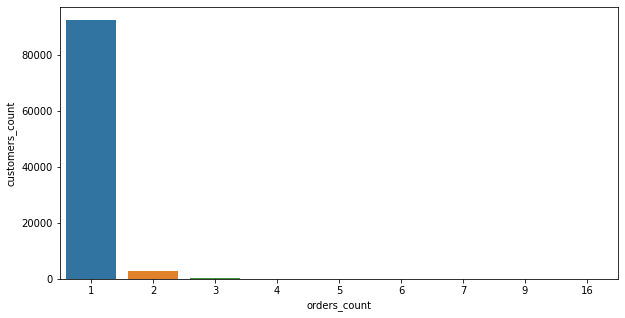

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(orders_per_customers.orders_count, orders_per_customers.customers_count)

In [32]:
# Из графика выше видно, что практически все пользователи совершают только одну покупку.

Таким образом, исходя из фрейма "orders_per_customers", число пользователей, совершивших только одну покупку (покупку в нашем предположении - имеет время подтверждения оплаты и не находится в статусе "недоступен"), составит  -  92515.

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [33]:
# Рассмотрим фрейм "customers_and_orders". Подсчитаем количество заказов, у которых статус != delivered или 
# нет времени доставки, сгруппируем по статусу и посчитаем количество таких заказов

In [34]:
not_delivered = customers_and_orders.query('order_status != "delivered" or order_delivered_customer_date.isna()').\
groupby('order_status', as_index = False).\
agg(not_delivered_count = ('order_id', 'count'))

In [35]:
not_delivered

,order_status,not_delivered_count
0,approved,2
1,canceled,625
2,created,5
3,delivered,8
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


Исключим из рассмотрения заказы со статусами: approved, created, invoiced, processing, shipped - так как это этапы поставки и нельзя считать, что товар не доставлен.
Рассмотрим заказы со статусами canceled и unavailable.

Также видим, что в получившемся фрейме присутствуют заказы со статусом delivered. Это означает, с учетом сделанного выше запроса, что заказ вроде как имеет статус доставлен, но времени доставки нет - такие заказы тоже рассмотрим как отдельный случай.

In [36]:
not_delivered_final = customers_and_orders.query('order_status == "canceled" \
or order_status == "unavailable" \
or order_status == "delivered" and order_delivered_customer_date.isna()')

In [37]:
not_delivered_final.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09
288,5bfe800011656c0afb81db64519982db,0071f46a072a9ae25bbe4438b15efe9c,16011,aracatuba,SP,df8c077268f7f3baaac0892eb3143642,unavailable,2017-02-01 00:04:17,2017-02-01 00:30:55,NaT,NaT,2017-03-10
373,b08064e24083fee8fbe8797902b07ecd,035f60af6e7d7f78470e9443be08d339,28495,aperibe,RJ,c609f82bcf7a90292a5940205ebd7e93,unavailable,2018-05-13 16:45:55,2018-05-13 17:11:58,NaT,NaT,2018-06-05
378,3ba47b09546c2da91ef141efce2d5888,b8c37ee810b38c416022e1c9f51e740c,32140,contagem,MG,a402af38a74c44926247db438245d95c,canceled,2018-01-30 22:12:10,2018-01-30 22:34:14,NaT,NaT,2018-03-06
380,cfffbb322333151f8df6398a8c3340db,0dc0731aafd5659410244092b0dc7d65,5093,sao paulo,SP,f63cd97f8f1db2eb266fb3bc2b4a95f3,canceled,2017-06-19 14:07:04,2017-06-19 14:23:18,NaT,NaT,2017-06-30


In [38]:
# Так как нам необходим сделать разбивку по месяцам, добавим во фрейм выше столбец с месяцами

In [39]:
not_delivered_final['order_purchase_month'] = not_delivered_final.order_purchase_timestamp.dt.strftime('%Y-%m')

In [40]:
not_delivered_final.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09,2018-03
288,5bfe800011656c0afb81db64519982db,0071f46a072a9ae25bbe4438b15efe9c,16011,aracatuba,SP,df8c077268f7f3baaac0892eb3143642,unavailable,2017-02-01 00:04:17,2017-02-01 00:30:55,NaT,NaT,2017-03-10,2017-02
373,b08064e24083fee8fbe8797902b07ecd,035f60af6e7d7f78470e9443be08d339,28495,aperibe,RJ,c609f82bcf7a90292a5940205ebd7e93,unavailable,2018-05-13 16:45:55,2018-05-13 17:11:58,NaT,NaT,2018-06-05,2018-05
378,3ba47b09546c2da91ef141efce2d5888,b8c37ee810b38c416022e1c9f51e740c,32140,contagem,MG,a402af38a74c44926247db438245d95c,canceled,2018-01-30 22:12:10,2018-01-30 22:34:14,NaT,NaT,2018-03-06,2018-01
380,cfffbb322333151f8df6398a8c3340db,0dc0731aafd5659410244092b0dc7d65,5093,sao paulo,SP,f63cd97f8f1db2eb266fb3bc2b4a95f3,canceled,2017-06-19 14:07:04,2017-06-19 14:23:18,NaT,NaT,2017-06-30,2017-06


In [41]:
# посмотрим, как менялось с течением времени количество недоставок в зависимости от статуса заказа

In [42]:
not_delivered_final_1 = not_delivered_final.groupby(['order_status', 'order_purchase_month'], as_index = False).\
agg(not_delivered_per_month = ('order_id', 'count'))

In [43]:
not_delivered_final_1.head()

,order_status,order_purchase_month,not_delivered_per_month
0,canceled,2016-09,2
1,canceled,2016-10,24
2,canceled,2017-01,3
3,canceled,2017-02,17
4,canceled,2017-03,33


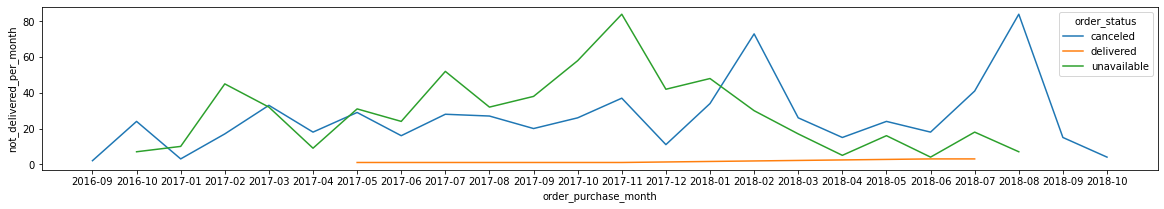

In [44]:
plt.figure(figsize=(20,3))
sns.lineplot(not_delivered_final_1.order_purchase_month,\
             not_delivered_final_1.not_delivered_per_month,\
             hue = not_delivered_final_1.order_status)

Из полученного графика можно сделать пару интересных выводов. 
Заказы со статусом "отменен" имеют два пика на рассматриваемом временном промежутке. Один приходится на февраль 2018, второй на август 2018. Исходя из этого, можно сделать предположение о том, что в августе родители начинают собирать детей в школу, заказывают много всего, а потом понимают, что часть из этого не требуется и отменяют заказ.
В феврале же также много заказов не доставляется по причине отмены - видимо из-за "разбитых сердец" на 14 февраля).

Еще один интересный момент полученного графика - сильно выраженный пик недоставок товаров со статусом "unavailable" в ноябре 2017. Что же там такого могло быть? Да еще и статус такой странный?

In [45]:
# посмотрим на количество оформленных и впоследствие купленных заказов по дням в ноябре 2017.
# Для этого используем фрейм "customers_and_orders_without_NAN_and_unav". 
# добавим колонку с днем и посчитаем число покупок в день

In [46]:
customers_and_orders_without_NAN_and_unav['order_purchase_timestamp_day'] = customers_and_orders_without_NAN_and_unav.order_purchase_timestamp.dt.strftime('%Y-%m-%d')


In [47]:
customers_and_orders_without_NAN_and_unav.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29


In [48]:
orders_in_2017_11 = customers_and_orders_without_NAN_and_unav.groupby(['order_purchase_timestamp_day'], as_index = False).\
agg(orders_per_day = ('order_id', 'count')).\
query('order_purchase_timestamp_day < "2017-12-01" and order_purchase_timestamp_day >= "2017-11-01"')

In [49]:
orders_in_2017_11.head()

,order_purchase_timestamp_day,orders_per_day
314,2017-11-01,109
315,2017-11-02,121
316,2017-11-03,138
317,2017-11-04,111
318,2017-11-05,141


In [50]:
# построим график по полученному выше фрейму

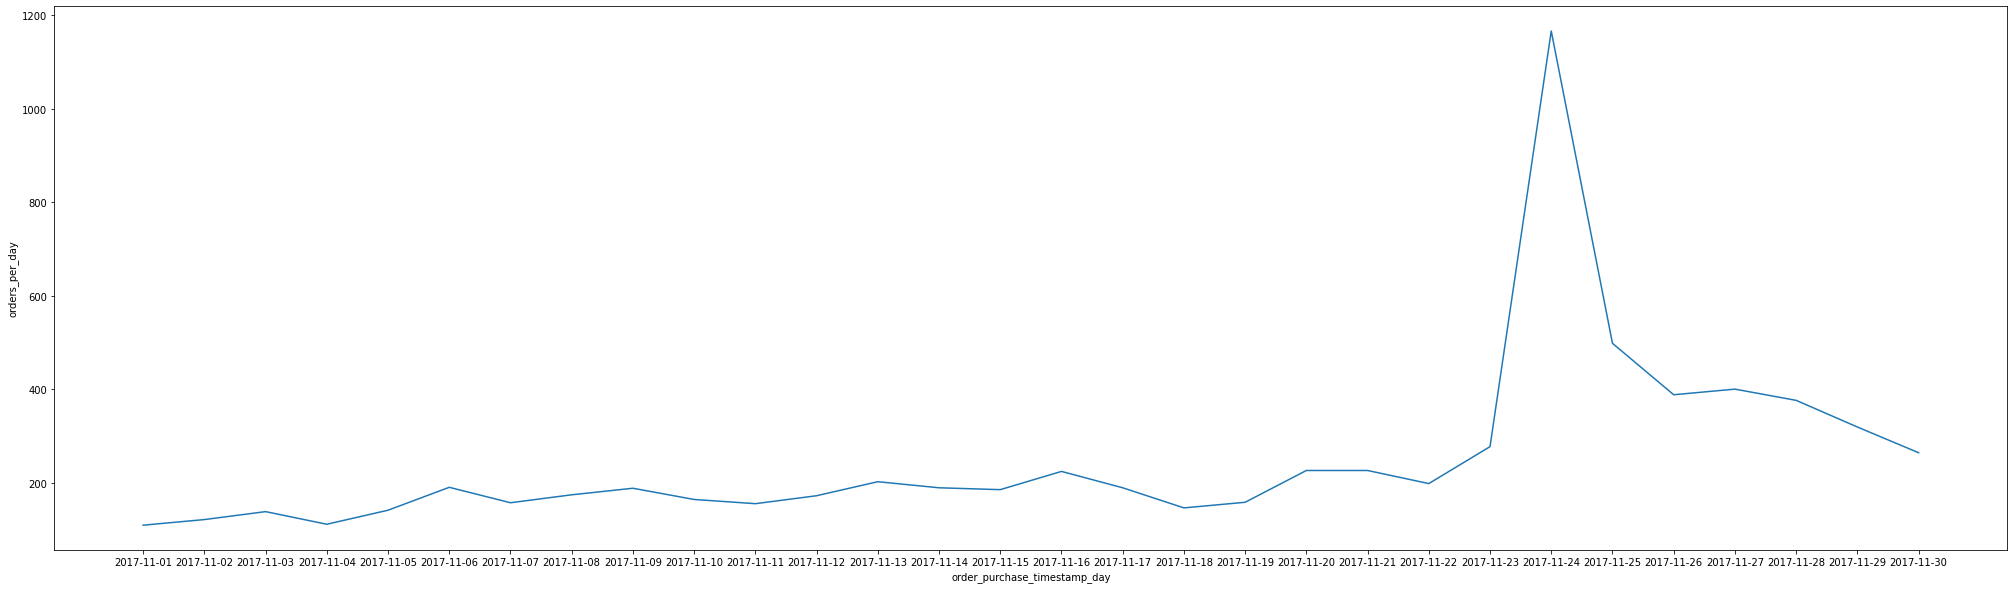

In [51]:
plt.figure(figsize=(35,10))
sns.lineplot(orders_in_2017_11.order_purchase_timestamp_day, orders_in_2017_11.orders_per_day)

Видим, что и в заказах, как и в недоставках есть явно выраженный пик по их количеству, причем в определенный день - 24 ноября 2017. Посмотрев на просторах интернета, обнаружено, что в этот день проходила всеми известная "Черная пятница". Этим можно объяснить как большое количество оформленных заказов, так и большое число недоставленных товаров со статусом "unavailable".
Огромное количество заказов и покупок в точечный момент времени -> системы перегружены -> происходят сбои -> странный статус заказа, как баг программы.

In [52]:
# сгруппируем получившийся фрейм "not_delivered_final" по статусу и месяцу, посчитаем число недоставок. 
# Впоследствие сгруппируемся снова по статусу заказа и посчитаем среднее число недоставок в месяц

In [53]:
not_delivered_final_per_month = not_delivered_final.groupby(['order_status', 'order_purchase_month'], as_index = False).\
agg({'order_id': 'count'}).\
groupby('order_status', as_index = False).\
agg(not_delivered_mean_per_month = ('order_id', 'mean')).\
round()

In [54]:
not_delivered_final_per_month

,order_status,not_delivered_mean_per_month
0,canceled,26.0
1,delivered,2.0
2,unavailable,29.0


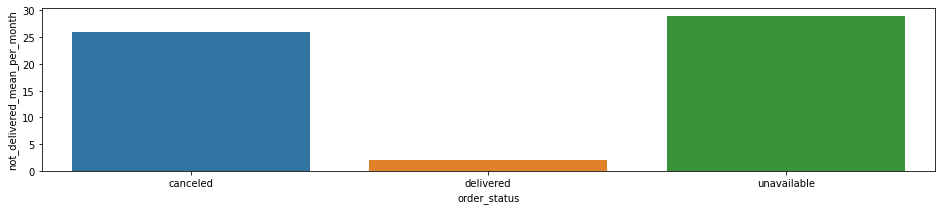

In [55]:
plt.figure(figsize=(16,3))
sns.barplot(not_delivered_final_per_month.order_status, not_delivered_final_per_month.not_delivered_mean_per_month)

Таким образом:  
    По причине отмены в среднем в месяц не доставляется 26 заказов;  
    По причине статуса "Unavailable" (багов?) - 29 заказов;  
    Заказов со статусом "Доставлен", при этом не имеющих времени доставки - в среднем 2 заказа в месяц (однако почему так происходит по имеющимся данным не ответить).

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Так как речь в данном задании идет о покупаемых товаров, то оставим в силе наше определение покупки - заказы, имеющие факт оплаты и вне статуса "unavailable".

Воспользуемся созданным ранее фреймом "customers_and_orders_without_NAN_and_unav" и объединим его с "items", в котором содержится информация о товарах.

In [56]:
for_items_per_days = customers_and_orders_without_NAN_and_unav.merge(items, how = 'inner', on = 'order_id')


In [57]:
for_items_per_days

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112623,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018-04-07,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
112624,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018-04-04,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
112625,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018-04-08,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
112626,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017-11-03,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


Создадим дополнительную колонку с названием дня недели и оставим только необходимые нам колонки.

In [58]:
for_items_per_days['day_name'] = for_items_per_days.order_approved_at.dt.day_name()

In [59]:
for_items_per_days_final = for_items_per_days[['product_id', 'day_name']]

In [60]:
for_items_per_days_final.head()

,product_id,day_name
0,a9516a079e37a9c9c36b9b78b10169e8,Tuesday
1,4aa6014eceb682077f9dc4bffebc05b0,Friday
2,bd07b66896d6f1494f5b86251848ced7,Sunday
3,a5647c44af977b148e0a3a4751a09e2e,Tuesday
4,9391a573abe00141c56e38d84d7d5b3b,Sunday


Сгруппируем полученный датафрейм и применим pandas.Series.mode, таким образом получив самые встречаемые дни недели для каждого продукта.

In [61]:
for_items_per_days_final.groupby('product_id', as_index = False).agg({'day_name': pd.Series.mode}).head()

,product_id,day_name
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Friday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

Так как в задании речь идет о покупках (определение мы уже дали выше), то воспользуемся полученным ранее фреймом "customers_and_orders_without_NAN_and_unav". Оставим только неоходимые для работы столбцы. Добавим столбец со значением месяца.

In [62]:
customers_and_orders_without_NAN_and_unav.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29


In [63]:
buy_per_weak = customers_and_orders_without_NAN_and_unav[['customer_unique_id', 'order_id','order_approved_at']]

In [64]:
buy_per_weak['month'] = buy_per_weak.order_approved_at.dt.to_period('M')

In [65]:
buy_per_weak.head()

,customer_unique_id,order_id,order_approved_at,month
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,2018-05
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,2018-07


Сгруппируем полученный фрейм по "customer_unique_id" и "month" и посчитаем количество покупок в месяц

In [66]:
buy_per_weak_final = buy_per_weak.groupby(['customer_unique_id', 'month'], as_index = False)\
.agg({'order_id': 'count'})\
.rename(columns = {'order_id': 'buy_per_month'})

In [67]:
buy_per_weak_final.sort_values('buy_per_month').tail(15)

,customer_unique_id,month,buy_per_month
53641,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08,3
68151,b2e9a05d23ea17713b5d7799f2004f8e,2018-07,3
23762,3e43e6105506432c953e165fb2acf44c,2017-12,3
35064,5bdb6f56a8fb4272b802f504bb6d1287,2018-02,3
64681,a9e070f61d35aa13e420c8597b5ccb3d,2018-01,3
37439,6222ef69df52b4ed71be551725551cc0,2017-01,3
88154,e78838df9c44e102b6ac84cc5eea7d5c,2017-02,3
23764,3e43e6105506432c953e165fb2acf44c,2018-02,4
76237,c8460e4251689ba205045f3ea17884a1,2018-08,4
14390,25a560b9a6006157838aab1bdbd68624,2017-04,4


Добавим колонку, которая считает количество недель в месяце.

In [68]:
buy_per_weak_final = buy_per_weak_final.assign(weeks_in_month = round(buy_per_weak_final.month.dt.days_in_month/7, 2))

In [69]:
buy_per_weak_final.head()

,customer_unique_id,month,buy_per_month,weeks_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.43
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.43
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.43
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.43
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.29


Выполним поставленную задачу и рассчитаем среднее количетсво покупок в неделю для каждого пользователя.

In [70]:
buy_per_weak_final['mean_buys_per_weak'] = (buy_per_weak_final.buy_per_month / buy_per_weak_final.weeks_in_month).round(2)

In [71]:
buy_per_weak_final.head()

,customer_unique_id,month,buy_per_month,weeks_in_month,mean_buys_per_weak
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.43,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.43,0.23
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.43,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.43,0.23
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.29,0.23


Как ответ на поставленный вопрос, оставим в датафрейме только две колонки

In [72]:
buy_per_weak_final_answer = buy_per_weak_final[['customer_unique_id', 'mean_buys_per_weak']]

In [73]:
buy_per_weak_final_answer.head()

,customer_unique_id,mean_buys_per_weak
0,0000366f3b9a7992bf8c76cfdf3221e2,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.23
2,0000f46a3911fa3c0805444483337064,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,0.23
4,0004aac84e0df4da2b147fca70cf8255,0.23


# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Когортный анализ подразумевает под собой исследование выделенного сегмента на определенном промежутке времени. Показатель retention подразумевает под собой исследование того, возвращаются к нам пользователи, чтобы совершить покупку еще раз или нет. 
Исходя из этого, так же как и на предыдущих шагах воспользуемся уже созданным фреймом "customers_and_orders_without_NAN_and_unav", в котором рассматриваются только пользователи, совершившие покупки (по нашему определению).
Так как мы уже исследовали исходные данные по времени и с учетом задания, единственным полным годом является 2017 - именно его и выберем для проведения когортного анализа.

In [74]:
customers_and_orders_without_NAN_and_unav.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29


Сгруппируем наши данные по уникальным пользователям и выведем дату первой покупки для каждого из них. Так как в задании требуется провести исследование по месяцам, то полученную колонку "month_of_first_buy" переведем в вид "год-месяц". Также отберем только месяцы 2017 года.

In [75]:
first_buy = customers_and_orders_without_NAN_and_unav\
.groupby('customer_unique_id',as_index = False)\
.agg({'order_approved_at':'min'})\
.rename(columns = {'order_approved_at':'month_of_first_buy'})

In [76]:
first_buy.head()

,customer_unique_id,month_of_first_buy
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52


In [77]:
first_buy['month_of_first_buy'] = first_buy.month_of_first_buy.dt.strftime('%Y-%m')

In [78]:
first_buy.head()

,customer_unique_id,month_of_first_buy
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [79]:
first_buy_2017 = first_buy[(first_buy.month_of_first_buy > '2016-12') & (first_buy.month_of_first_buy <'2018-01')]

In [80]:
first_buy_2017.head()

,customer_unique_id,month_of_first_buy
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11
8,0005e1862207bf6ccc02e4228effd9a0,2017-03
10,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07


In [81]:
first_buy_2017.customer_unique_id.nunique()

43157

In [82]:
first_buy_2017.month_of_first_buy.unique()

array(['2017-03', '2017-10', '2017-11', '2017-07', '2017-08', '2017-09',
       '2017-12', '2017-01', '2017-04', '2017-06', '2017-02', '2017-05'],
      dtype=object)

Теперь выведем месяцы для всех покупок (не только первых).

In [83]:
customers_and_orders_without_NAN_and_unav['other_buy'] = customers_and_orders_without_NAN_and_unav.order_approved_at.dt.strftime('%Y-%m')

In [84]:
customers_and_orders_without_NAN_and_unav.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_day,other_buy
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29,2018-07


Смержим два полученных фрейма, чтобы получить таблицу с уникальными пользователями, месяцами их первых покупок и месяцами остальных покупок.

In [85]:
buys = first_buy_2017.merge(customers_and_orders_without_NAN_and_unav[['other_buy','customer_unique_id']], on='customer_unique_id', how='left') 

In [86]:
buys.customer_unique_id.nunique()

43157

In [87]:
buys.head()

,customer_unique_id,month_of_first_buy,other_buy
0,0000f46a3911fa3c0805444483337064,2017-03,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07,2017-07


Теперь перегруппируем полученный фрейм, чтобы получить количество уникальных клиентов, которые сделали первую покупку в month_of_first_buy, и в other_buy. Также создадим фрейм, в котором посчитаем количество покупок в месяц.

In [88]:
unique_buy = buys.groupby(['month_of_first_buy','other_buy'],as_index = False)\
    .agg({'customer_unique_id':'nunique'})\
    .rename(columns = {'customer_unique_id':'quantity_of_uniq_clients'})

In [89]:
unique_buy.head()

,month_of_first_buy,other_buy,quantity_of_uniq_clients
0,2017-01,2017-01,718
1,2017-01,2017-02,4
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3


In [90]:
first_month_buy = buys.groupby('month_of_first_buy',as_index = False)\
    .agg({'customer_unique_id':'nunique'})\
    .rename(columns ={'customer_unique_id':'unique_customers'})

In [91]:
first_month_buy.head()

,month_of_first_buy,unique_customers
0,2017-01,718
1,2017-02,1689
2,2017-03,2611
3,2017-04,2314
4,2017-05,3561


Создадим финальный фрейм для расчета "retention rate".

In [92]:
final_table = unique_buy.merge(first_month_buy, on = 'month_of_first_buy', how = 'left')

In [93]:
final_table.head(15)

,month_of_first_buy,other_buy,quantity_of_uniq_clients,unique_customers
0,2017-01,2017-01,718,718
1,2017-01,2017-02,4,718
2,2017-01,2017-03,2,718
3,2017-01,2017-04,1,718
4,2017-01,2017-05,3,718
5,2017-01,2017-06,1,718
6,2017-01,2017-07,3,718
7,2017-01,2017-08,1,718
8,2017-01,2017-09,1,718
9,2017-01,2017-11,2,718


Так как в полученным фрейме имеются данные для пользователей, которые совершили повторные покупки позже 2017 года (а нам они для исследования не нужны), то избавимся от таких данных.

In [94]:
final_table = final_table[final_table.other_buy <'2018-04']

In [95]:
final_table.head(12)

,month_of_first_buy,other_buy,quantity_of_uniq_clients,unique_customers
0,2017-01,2017-01,718,718
1,2017-01,2017-02,4,718
2,2017-01,2017-03,2,718
3,2017-01,2017-04,1,718
4,2017-01,2017-05,3,718
5,2017-01,2017-06,1,718
6,2017-01,2017-07,3,718
7,2017-01,2017-08,1,718
8,2017-01,2017-09,1,718
9,2017-01,2017-11,2,718


Расчитаем "retention rate".

In [96]:
final_table['retention'] = round((final_table['quantity_of_uniq_clients'] / final_table['unique_customers']),4)

In [97]:
final_table.head()

,month_of_first_buy,other_buy,quantity_of_uniq_clients,unique_customers,retention
0,2017-01,2017-01,718,718,1.0000
1,2017-01,2017-02,4,718,0.0056
2,2017-01,2017-03,2,718,0.0028
3,2017-01,2017-04,1,718,0.0014
4,2017-01,2017-05,3,718,0.0042


Для составления финального фрейма воспользуемся функцией pivot.

In [98]:
retention = final_table.pivot(index = 'month_of_first_buy', columns = 'other_buy', values = 'retention')

In [99]:
retention

other_buy,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
month_of_first_buy,,,,,,,,,,,,,,,
2017-01,1.0,0.0056,0.0028,0.0014,0.0042,0.0014,0.0042,0.0014,0.0014,NaN,0.0028,0.0028,0.0070,0.0042,0.0014
2017-02,NaN,1.0000,0.0024,0.0024,0.0018,0.0041,0.0012,0.0024,0.0018,0.0006,0.0018,0.0012,0.0030,0.0012,0.0018
2017-03,NaN,NaN,1.0000,0.0050,0.0034,0.0034,0.0034,0.0015,0.0015,0.0031,0.0031,0.0011,0.0038,0.0011,0.0023
2017-04,NaN,NaN,NaN,1.0000,0.0061,0.0022,0.0017,0.0030,0.0026,0.0035,0.0026,0.0035,0.0017,0.0022,0.0009
2017-05,NaN,NaN,NaN,NaN,1.0000,0.0053,0.0048,0.0039,0.0031,0.0034,0.0042,0.0014,0.0025,0.0028,0.0028
2017-06,NaN,NaN,NaN,NaN,NaN,1.0000,0.0048,0.0035,0.0038,0.0026,0.0035,0.0038,0.0022,0.0013,0.0022
2017-07,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0053,0.0034,0.0018,0.0034,0.0018,0.0032,0.0011,0.0018
2017-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0067,0.0036,0.0026,0.0038,0.0053,0.0026,0.0026
2017-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0066,0.0049,0.0034,0.0041,0.0027,0.0022


Для удобства восприятия сделаем небольшие преобразования. Вернемся к фрейму "retention". Создадим колонку "number_of_past_month" для удобства, которая будет нам показывать, сколько для каждого из месяцев покупок было совершено в следующий месяц и т.д. (0 - тот же месяц, 1 - следующий и т.д.). После чего опять с помощью pivot построим сводную таблицу "retention_1".

In [100]:
final_table['number_of_pas_month'] = ((final_table.other_buy.astype('datetime64[M]') - final_table.month_of_first_buy.astype('datetime64[M]'))/np.timedelta64(1, 'M')).round().astype(int)

In [101]:
final_table.head()

,month_of_first_buy,other_buy,quantity_of_uniq_clients,unique_customers,retention,number_of_pas_month
0,2017-01,2017-01,718,718,1.0000,0
1,2017-01,2017-02,4,718,0.0056,1
2,2017-01,2017-03,2,718,0.0028,2
3,2017-01,2017-04,1,718,0.0014,3
4,2017-01,2017-05,3,718,0.0042,4


In [102]:
retention_1 = final_table.pivot(index = 'month_of_first_buy', columns = 'number_of_pas_month', values = 'retention')

In [103]:
retention_1

number_of_pas_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
month_of_first_buy,,,,,,,,,,,,,,,
2017-01,1.0,0.0056,0.0028,0.0014,0.0042,0.0014,0.0042,0.0014,0.0014,NaN,0.0028,0.0028,0.0070,0.0042,0.0014
2017-02,1.0,0.0024,0.0024,0.0018,0.0041,0.0012,0.0024,0.0018,0.0006,0.0018,0.0012,0.0030,0.0012,0.0018,NaN
2017-03,1.0,0.0050,0.0034,0.0034,0.0034,0.0015,0.0015,0.0031,0.0031,0.0011,0.0038,0.0011,0.0023,NaN,NaN
2017-04,1.0,0.0061,0.0022,0.0017,0.0030,0.0026,0.0035,0.0026,0.0035,0.0017,0.0022,0.0009,NaN,NaN,NaN
2017-05,1.0,0.0053,0.0048,0.0039,0.0031,0.0034,0.0042,0.0014,0.0025,0.0028,0.0028,NaN,NaN,NaN,NaN
2017-06,1.0,0.0048,0.0035,0.0038,0.0026,0.0035,0.0038,0.0022,0.0013,0.0022,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.0053,0.0034,0.0018,0.0034,0.0018,0.0032,0.0011,0.0018,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.0067,0.0036,0.0026,0.0038,0.0053,0.0026,0.0026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.0066,0.0049,0.0034,0.0041,0.0027,0.0022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для еще большей наглядности воспользуемся "heatmap", который часто используется для представления результатов когортного анализа.

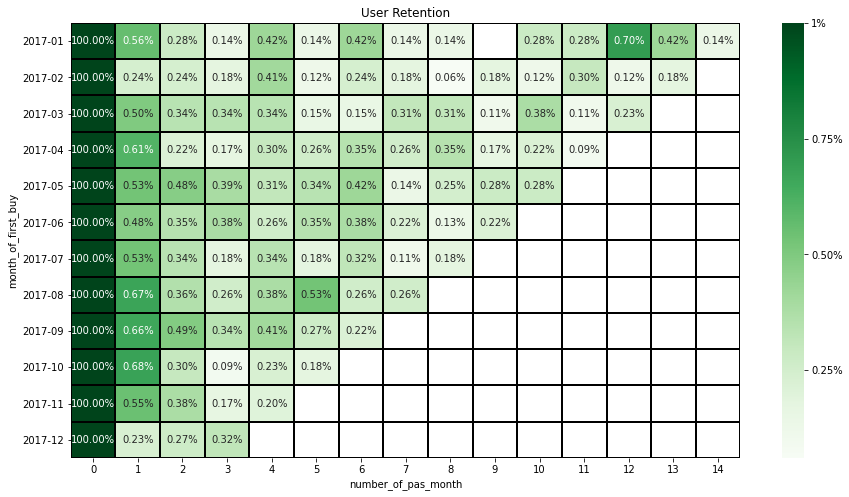

In [104]:
plt.figure(figsize=(15, 8))
plt.title('User Retention')
ax = sns.heatmap(retention_1, annot=True, fmt='.2%',vmax=0.01, linewidths=1, linecolor='black', cmap = "Greens")
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .0025, .005, .0075, 0.01])
cbar.set_ticklabels(['0%', '0.25%', '0.50%', '0.75%', '1%'])

По тепловой карте находим ответ на поставленный вопрос в задаче.

Когорта с наивысшим "retention rate" на третий месяц - уникальные пользователи, совершившие первую покупку в Мае 2017.

# 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

Так как RFM - сегментация рассматривает пользователей, совершивших покупки, то воспользуемся фреймом "customers_and_orders_without_NAN_and_unav". Так как в RFM необходим подсчет средств, то необходимо также учеть датафрейм "items". В 3 задании мы уже совмещали два данных фрейма, поэтому воспользуемся, полученным на том шаге "for_items_per_days" для решения поставленной задачи (для удобства переименуем его и оставим только необходимые колонки).

In [105]:
for_RFM = for_items_per_days[['order_id', 'order_approved_at', 'customer_unique_id', 'price']]

In [106]:
for_RFM.head()

,order_id,order_approved_at,customer_unique_id,price
0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,861eff4711a542e4b93843c6dd7febb0,124.99
1,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,290c77bc529b7ac935b93aa66c333dc3,289.00
2,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,060e732b5b29e8181a18229c7b0b2b5e,139.94
3,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,259dac757896d24d7702b9acbbff3f3c,149.94
4,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,345ecd01c38d18a9036ed96c73b8d066,230.00


Посмотрим, какой временой интервал охватывает наш полученный фрейм. А также на дату последней покупки.

In [107]:
for_RFM['order_approved_at'].max() - for_RFM['order_approved_at'].min()

Timedelta('718 days 05:23:28')

In [108]:
last_date = for_RFM['order_approved_at'].max()

In [109]:
last_date

Timestamp('2018-09-03 17:40:06')

Как видим, охватываемый диапазон составляет чуть больше 718 дней, а последняя покупка была совершена в сентябре 2018. Поэтому для проведения RFM анализа возьмем за точку отсчета дату - следующую за днем последней оплаты.

In [110]:
NOW = for_RFM['order_approved_at'].max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 17:40:06')

Сгруппируем полученный фрейм по уникальным пользователям и произведем расчет показателей RFM.

In [111]:
RFM = for_RFM.groupby('customer_unique_id', as_index=False)\
.agg({'order_approved_at': lambda x: (last_date - x.max()).days, 
      'order_id': 'count', 
      'price': 'sum'})\
.rename(columns={'order_approved_at'  : 'recency', 
                 'order_id'    : 'frequency', 
                 'price': 'monetary'})

In [112]:
RFM.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90
2,0000f46a3911fa3c0805444483337064,541,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00


Посмотрим на распределения полученных нами колонок и определимся с разбиенем для них.

In [113]:
RFM.recency.describe()

count    95401.000000
mean       242.614103
std        153.089456
min          0.000000
25%        118.000000
50%        223.000000
75%        352.000000
max        718.000000
Name: recency, dtype: float64

С учетом того, что весь временной диапазон составляет 718 дней, в целом для метрики "recensy" можно использовать разбиение по квартилям.

In [114]:
RFM.frequency.describe()

count    95401.000000
mean         1.180575
std          0.621490
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: frequency, dtype: float64

Для "frequency" по квартилям разбивать абсолютно нецелесообразно.

In [115]:
RFM.groupby('frequency').customer_unique_id.count()

frequency
1     83535
2      8993
3      1672
4       632
5       254
6       198
7        46
8        16
9        11
10       11
11       11
12        9
13        2
14        3
15        2
16        1
18        1
20        2
21        1
24        1
Name: customer_unique_id, dtype: int64

В соответствии с тем, что практически 88 % пользователей совершили только одну покупку, целесообразней в данном случае будет сделать разбиение "вручную".

1 - пользователи, совершившие 1 покупку;
2 - 2 покупки;
3 - 3 покупки;
4 - 4-6 покупок;
5 - 7 и более покупок.

In [116]:
RFM.monetary.describe()

count    95401.000000
mean       142.430012
std        217.645932
min          0.850000
25%         47.900000
50%         89.900000
75%        155.000000
max      13440.000000
Name: monetary, dtype: float64

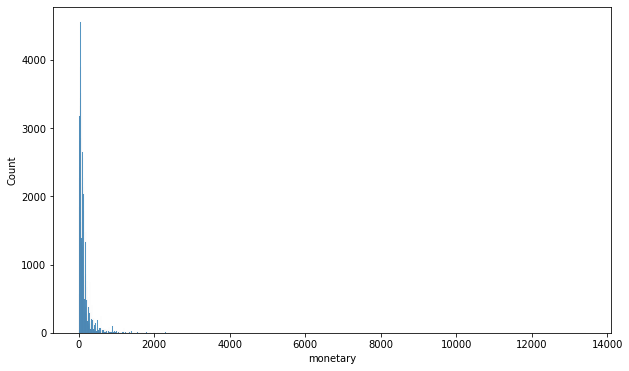

In [117]:
plt.figure(figsize=(10, 6))
sns.histplot(RFM.monetary)

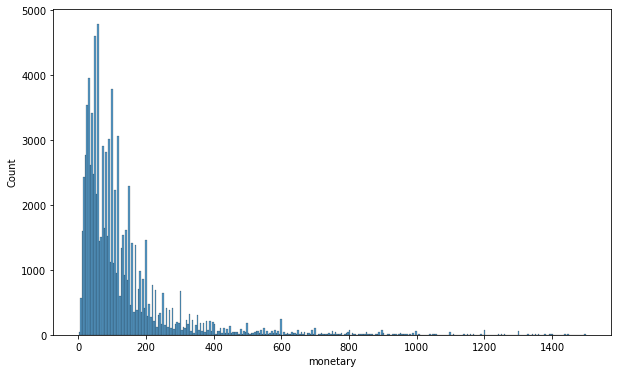

In [118]:
plt.figure(figsize=(10, 6))
sns.histplot(RFM[RFM.monetary < 1500], x = 'monetary')

В целом, и в описательной статистики датфрейма, и на графиках видно, что большинство пользователей потратили менее 200 у.е. Вполне уместно для "monetary" использовать квартильный подход.

Создадим словарь со значениями наших разбиений.

In [119]:
razbienie = RFM[['recency','monetary']].quantile([.2, .4, .6, .8])

In [120]:
razbienie['frequency'] = [1, 2, 3, 6]

In [121]:
quant = razbienie.to_dict()

In [122]:
quant

{'recency': {0.2: 97.0, 0.4: 181.0, 0.6: 272.0, 0.8: 388.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9},
 'frequency': {0.2: 1, 0.4: 2, 0.6: 3, 0.8: 6}}

Создадим функции для определения ранга наших пользователей.

In [123]:
def R(x):
    if x <= quant['recency'][.2]:
        return 5
    elif x <= quant['recency'][.4]:
        return 4
    elif x <= quant['recency'][.6]:
        return 3
    elif x <= quant['recency'][.8]:
        return 2
    else:
        return 1

def FM(x, c):
    if x <= quant[c][.2]:
        return 1
    elif x <= quant[c][.4]:
        return 2
    elif x <= quant[c][.6]:
        return 3
    elif x <= quant[c][.8]:
        return 4
    else:
        return 5 

In [124]:
RFM['R'] = RFM['recency'].apply(lambda x: R(x))
RFM['F'] = RFM['frequency'].apply(lambda x: FM(x, 'frequency'))
RFM['M'] = RFM['monetary'].apply(lambda x: FM(x, 'monetary'))
RFM['RFM_score'] = RFM.R.map(str) + RFM.F.map(str) + RFM.M.map(str)

In [125]:
RFM.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,2,1,5,215


Для лучшего восприятия можно разбить всех пользователей на основе их RFM - рейтинга на группы.

Основываясь на их RF значениях были выделены следующие группы:

    1) Лучшие пользователи - Покупали недавно, покупают часто и тратят больше всего;
    2) Постоянные клиенты - Покупают на постоянной основе;
    3) Потенциальные лояльные пользователи - Покупатели со средней частотой покупок;
    4) Недавние клиенты - Покупали совсем недавно, но не часто;
    5) Многообещающие - Недавние покупатели, но потратили не так уж много;
    6) Нуждающиеся во внимании - Выше среднего по новизне, частоте и денежным ценностям. Хотя, возможно, совершали покупки не совсем недавно;
    7) Малоактивные - С частотой ниже средней;
    8) В зоне риска - Приобретали часто, но давным-давно. Нужно вернуть их обратно!;
    9) Не можем их потерять - Совершали покупки часто, но долгое время не возвращались.
    10) Неактивные - Последняя покупка была совершена давно и с небольшим количеством заказов. Может быть потерян.

In [126]:
segt_map = {
    r'[1-2][1-2]': 'Неактивные',
    r'[1-2][3-4]': 'В зоне риска',
    r'[1-2]5': 'Не можем их потерять',
    r'3[1-2]': 'Малоактивные',
    r'33': 'Нуждающиеся во внимании',
    r'[3-4][4-5]': 'Постоянные клиенты',
    r'41': 'Многообещающие',
    r'51': 'Недавние клиенты',
    r'[4-5][2-3]': 'Потенциальные лояльные пользователи',
    r'5[4-5]': 'Лучшие пользователи'
}

RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414,Многообещающие
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,1,411,Многообещающие
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1,1,2,112,Неактивные
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,2,1,1,211,Неактивные
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,2,1,5,215,Неактивные


После того, как мы полуличли RFM-оценки для наших пользователей, мы можем провести некоторую визуализацию данных, чтобы получить лучшее представление о них. Для начала посмотрим на распределения R, F и M.

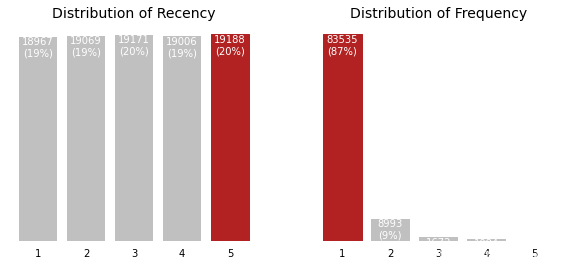

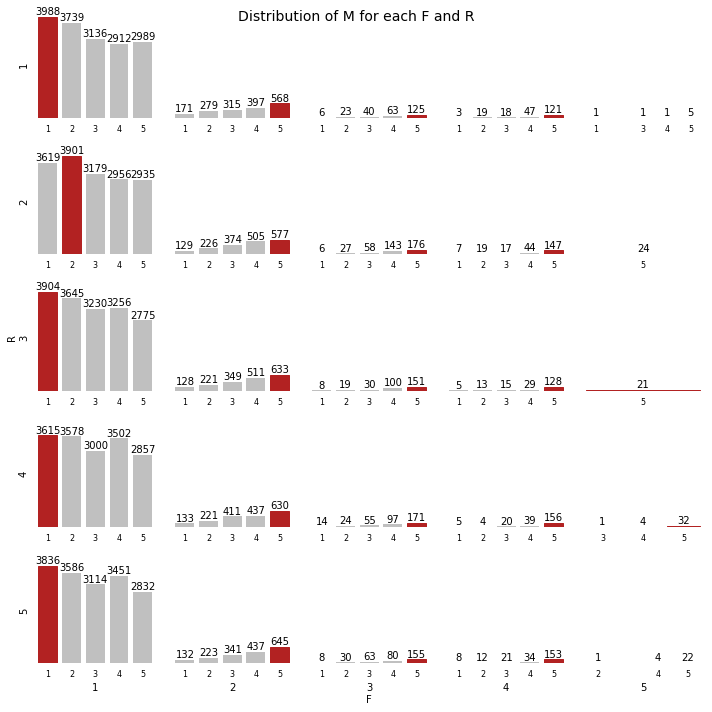

In [127]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = RFM[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = RFM[(RFM['R'] == r) & (RFM['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

И напоследок посмотрим на распределения для наших сегментов.

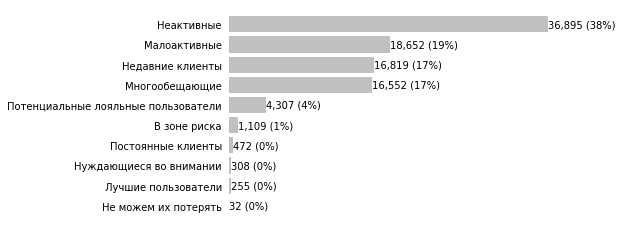

In [128]:
# count the number of customers in each segment
segments_counts = RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Исходя из данного графика можно сказать следующее:

Мы видим, что 38 % наших пользователей на данный момент являются "Неактивными". 
При этом достаточно большой процент пользователей имеют статус "Недавних" или "Многообещающих" пользователей.
Также нашей фирме нужно обратить внимание на "Малоактивных" и "Потенциальных" пользователей (может быть привлечь их к большим покупкам с помощью промо или предложенных скидок).

С учетом полученных ранее результатов, например того, что в ходе работы мы заметили, что большинство пользователей совершили в нашей фирме только одну покупку, а также на низкий "retention rate" - можно сделать предположение, что фирма является продавцом редкопокупаемых товаров (например, электроника или бытовая техника).